In [ ]:
import zipfile
import os

# Define the file and zip file paths
file_to_zip = '/kaggle/working/photo_to_sketch.pth'  # Replace with your file path
zip_file_name = '/kaggle/working/my_file.zip'  # Output zip file path

# Create a zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    zipf.write(file_to_zip, os.path.basename(file_to_zip))

print(f"File zipped successfully: {zip_file_name}")


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

# -----------------------------
# Image Dataset Class for CycleGAN
# -----------------------------
class ImageDataset(Dataset):
    def __init__(self, root_photos, root_sketches, transform=None):
        self.transform = transform
        self.photo_paths = sorted([os.path.join(root_photos, f) for f in os.listdir(root_photos)])
        self.sketch_paths = sorted([os.path.join(root_sketches, f) for f in os.listdir(root_sketches)])

    def __len__(self):
        return len(self.photo_paths)

    def __getitem__(self, idx):
        photo = Image.open(self.photo_paths[idx]).convert("RGB")
        sketch = Image.open(self.sketch_paths[idx]).convert("RGB")

        if self.transform:
            photo = self.transform(photo)
            sketch = self.transform(sketch)
        return photo, sketch

# -----------------------------
# CycleGAN Generator Network
# -----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        conv_block = [nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
                      nn.InstanceNorm2d(in_features), nn.ReLU(inplace=True),
                      nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
                      nn.InstanceNorm2d(in_features)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
        # Encoder
        model = [nn.Conv2d(input_nc, 64, kernel_size=7, stride=1, padding=3),
                 nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
                 nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                 nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
                 nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                 nn.InstanceNorm2d(256), nn.ReLU(inplace=True)]

        # Transformer (Residual Blocks)
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(256)]

        # Decoder
        model += [nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
                  nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
                  nn.Conv2d(64, output_nc, kernel_size=7, stride=1, padding=3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

# -----------------------------
# CycleGAN Discriminator Network (PatchGAN)
# -----------------------------
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()
        model = [nn.Conv2d(input_nc, 64, kernel_size=4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
                 nn.InstanceNorm2d(128), nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
                 nn.InstanceNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
                 nn.InstanceNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
                 nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


# -----------------------------
# Loss and Weight Initializer
# -----------------------------
def init_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias.data, 0)

# -----------------------------
# Helper Function to Load Weights
# -----------------------------
def load_weights_if_available(model, model_path):
    if os.path.exists(model_path) and model_path != 'nil':  # 'nil' indicates start from scratch
        model.load_state_dict(torch.load(model_path,weights_only=True))
        print(f'Loaded weights from {model_path}')
    else:
        print(f'No weights found at {model_path}, starting training from scratch.')

# -----------------------------
# Image Transformation Setup
# -----------------------------
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# -----------------------------
# DataLoader Setup
# -----------------------------
dataset = ImageDataset(root_photos='/kaggle/input/photosandsketches/train/photos',
                       root_sketches='/kaggle/input/photosandsketches/train/sketches',
                       transform=transform)

dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# -----------------------------
# Device Setup (GPU or CPU)
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Instantiate Networks
# -----------------------------
G_photo2sketch = nn.DataParallel(Generator(3, 3).to(device))
G_sketch2photo = nn.DataParallel(Generator(3, 3).to(device))
D_sketch = nn.DataParallel(Discriminator(3).to(device))
D_photo = nn.DataParallel(Discriminator(3).to(device))

# Initialize weights
init_weights(G_photo2sketch)
init_weights(G_sketch2photo)
init_weights(D_sketch)
init_weights(D_photo)

# -----------------------------
# Load Pretrained Weights (if available)
# -----------------------------
G_photo2sketch_path = '/kaggle/working/photo_to_sketch.pth'
G_sketch2photo_path = '/kaggle/working/sketch_to_photo.pth'
D_sketch_path = '/kaggle/working/D_sketch.pth'
D_photo_path = '/kaggle/working/D_photo.pth'

load_weights_if_available(G_photo2sketch, G_photo2sketch_path)
load_weights_if_available(G_sketch2photo, G_sketch2photo_path)
load_weights_if_available(D_sketch, D_sketch_path)
load_weights_if_available(D_photo, D_photo_path)

# -----------------------------
# Define Losses and Optimizers
# -----------------------------
criterion_GAN = nn.MSELoss().to(device)  # GAN Loss
criterion_cycle = nn.L1Loss().to(device)  # Cycle Consistency Loss

optimizer_G = optim.Adam(list(G_photo2sketch.parameters()) + list(G_sketch2photo.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_sketch = optim.Adam(D_sketch.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_photo = optim.Adam(D_photo.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cycle = 10  # Cycle consistency weight

# -----------------------------
# Training Loop with Progress Tracking and Saving Weights
# -----------------------------
epochs = 15
for epoch in range(epochs):
    for i, (real_photo, real_sketch) in enumerate(dataloader):
        real_photo = real_photo.to(device)
        real_sketch = real_sketch.to(device)

        # Train Discriminators
        # Sketch Discriminator
        fake_sketch = G_photo2sketch(real_photo).detach()
        loss_D_sketch_real = criterion_GAN(D_sketch(real_sketch), torch.ones_like(D_sketch(real_sketch)))
        loss_D_sketch_fake = criterion_GAN(D_sketch(fake_sketch), torch.zeros_like(D_sketch(fake_sketch)))
        loss_D_sketch = (loss_D_sketch_real + loss_D_sketch_fake) * 0.5

        optimizer_D_sketch.zero_grad()
        loss_D_sketch.backward()
        optimizer_D_sketch.step()

        # Photo Discriminator
        fake_photo = G_sketch2photo(real_sketch).detach()
        loss_D_photo_real = criterion_GAN(D_photo(real_photo), torch.ones_like(D_photo(real_photo)))
        loss_D_photo_fake = criterion_GAN(D_photo(fake_photo), torch.zeros_like(D_photo(fake_photo)))
        loss_D_photo = (loss_D_photo_real + loss_D_photo_fake) * 0.5

        optimizer_D_photo.zero_grad()
        loss_D_photo.backward()
        optimizer_D_photo.step()

        # Train Generators
        # GAN Loss for Generators
        loss_G_photo2sketch = criterion_GAN(D_sketch(G_photo2sketch(real_photo)), torch.ones_like(D_sketch(fake_sketch)))
        loss_G_sketch2photo = criterion_GAN(D_photo(G_sketch2photo(real_sketch)), torch.ones_like(D_photo(fake_photo)))

        # Cycle Consistency Loss
        cycle_photo = G_sketch2photo(fake_sketch)
        cycle_sketch = G_photo2sketch(fake_photo)
        loss_cycle_photo = criterion_cycle(cycle_photo, real_photo) * lambda_cycle
        loss_cycle_sketch = criterion_cycle(cycle_sketch, real_sketch) * lambda_cycle

        loss_G = loss_G_photo2sketch + loss_G_sketch2photo + loss_cycle_photo + loss_cycle_sketch

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        # Print progress every 100 batches
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}] | Batch [{i + 1}/{len(dataloader)}] | '
                  f'Processed {((i + 1) * dataloader.batch_size)} images so far')

    # -----------------------------
    # Save Weights at Every Epoch
    # -----------------------------
    torch.save(G_photo2sketch.state_dict(), '/kaggle/working/photo_to_sketch.pth')
    torch.save(G_sketch2photo.state_dict(), '/kaggle/working/sketch_to_photo.pth')
    torch.save(D_sketch.state_dict(), '/kaggle/working/D_sketch.pth')
    torch.save(D_photo.state_dict(), '/kaggle/working/D_photo.pth')

    print(f'Epoch [{epoch + 1}/{epochs}] completed and weights saved.')
    print(f'Epoch [{epoch + 1}/{epochs}] | Loss_G: {loss_G.item()}, Loss_D_Sketch: {loss_D_sketch.item()}, Loss_D_Photo: {loss_D_photo.item()}')


Loaded weights from /kaggle/working/photo_to_sketch.pth
Loaded weights from /kaggle/working/sketch_to_photo.pth
Loaded weights from /kaggle/working/D_sketch.pth
Loaded weights from /kaggle/working/D_photo.pth
Epoch [1/15] completed and weights saved.
Epoch [1/15] | Loss_G: 3.10345721244812, Loss_D_Sketch: 0.26928481459617615, Loss_D_Photo: 0.23651187121868134
Epoch [2/15] completed and weights saved.
Epoch [2/15] | Loss_G: 3.405789852142334, Loss_D_Sketch: 0.2750621736049652, Loss_D_Photo: 0.25413012504577637
Epoch [3/15] completed and weights saved.
Epoch [3/15] | Loss_G: 2.9077107906341553, Loss_D_Sketch: 0.25913816690444946, Loss_D_Photo: 0.2559564709663391
Epoch [4/15] completed and weights saved.
Epoch [4/15] | Loss_G: 3.0967321395874023, Loss_D_Sketch: 0.2606881558895111, Loss_D_Photo: 0.2270551323890686
Epoch [5/15] completed and weights saved.
Epoch [5/15] | Loss_G: 3.1728909015655518, Loss_D_Sketch: 0.2544560432434082, Loss_D_Photo: 0.26950201392173767
Epoch [6/15] completed a

/tmp/ipykernel_30/694570000.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


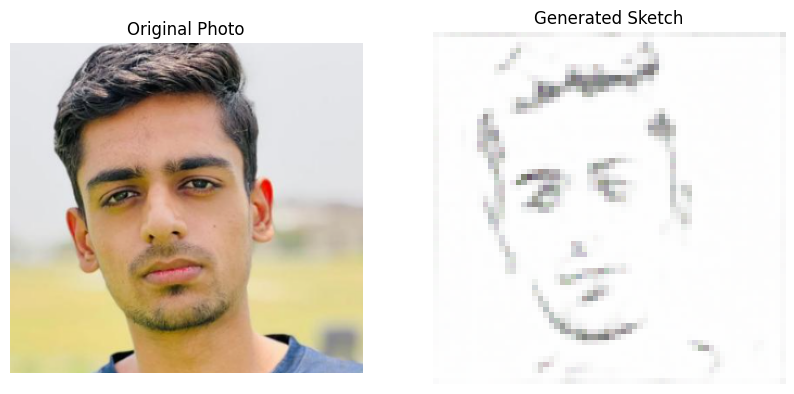

In [15]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def photo_to_sketch(image_path, model_path='/kaggle/working/photo_to_sketch.pth'):
    # Load the pre-trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Generator(3, 3).to(device)
    
    # Load the state dict and remove the "module." prefix if it exists
    state_dict = torch.load(model_path, map_location=device)
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[name] = v
    
    model.load_state_dict(new_state_dict)
    model.eval()

    # Prepare the image
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load and transform the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Generate the sketch
    with torch.no_grad():
        sketch_tensor = model(img_tensor)

    # Convert the tensor to an image
    sketch_image = sketch_tensor.squeeze().cpu().permute(1, 2, 0)
    sketch_image = (sketch_image * 0.5 + 0.5).numpy()

    # Display the original photo and the generated sketch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img)
    ax1.set_title('Original Photo')
    ax1.axis('off')
    ax2.imshow(sketch_image)
    ax2.set_title('Generated Sketch')
    ax2.axis('off')
    plt.show()

# Usage example:
# photo_to_sketch('path/to/your/photo.jpg')

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
        # Encoder
        model = [nn.Conv2d(input_nc, 64, kernel_size=7, stride=1, padding=3),
                 nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
                 nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                 nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
                 nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                 nn.InstanceNorm2d(256), nn.ReLU(inplace=True)]

        # Transformer (Residual Blocks)
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(256)]

        # Decoder
        model += [nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
                  nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
                  nn.Conv2d(64, output_nc, kernel_size=7, stride=1, padding=3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        conv_block = [nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
                      nn.InstanceNorm2d(in_features), nn.ReLU(inplace=True),
                      nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
                      nn.InstanceNorm2d(in_features)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)




photo_to_sketch('/kaggle/input/danish/danish.PNG')

/tmp/ipykernel_30/409218997.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=device)


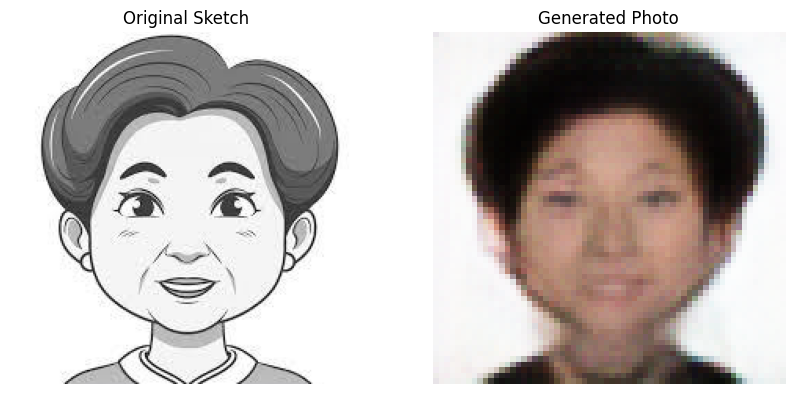

In [21]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def sketch_to_photo(image_path, model_path='/kaggle/working/sketch_to_photo.pth'):
    # Load the pre-trained model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Generator(3, 3).to(device)
    
    # Load the state dict and remove the "module." prefix if it exists
    state_dict = torch.load(model_path, map_location=device)
    new_state_dict = {}
    for k, v in state_dict.items():
        name = k.replace("module.", "") if k.startswith("module.") else k
        new_state_dict[name] = v
    
    model.load_state_dict(new_state_dict)
    model.eval()

    # Prepare the image
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Load and transform the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Generate the photo
    with torch.no_grad():
        photo_tensor = model(img_tensor)

    # Convert the tensor to an image
    photo_image = photo_tensor.squeeze().cpu().permute(1, 2, 0)
    photo_image = (photo_image * 0.5 + 0.5).numpy()

    # Display the original sketch and the generated photo
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(img)
    ax1.set_title('Original Sketch')
    ax1.axis('off')
    ax2.imshow(photo_image)
    ax2.set_title('Generated Photo')
    ax2.axis('off')
    plt.show()

# Usage example:
# sketch_to_photo('path/to/your/sketch.jpg')

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
        # Encoder
        model = [nn.Conv2d(input_nc, 64, kernel_size=7, stride=1, padding=3),
                 nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
                 nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                 nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
                 nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
                 nn.InstanceNorm2d(256), nn.ReLU(inplace=True)]

        # Transformer (Residual Blocks)
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(256)]

        # Decoder
        model += [nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(128), nn.ReLU(inplace=True),
                  nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                  nn.InstanceNorm2d(64), nn.ReLU(inplace=True),
                  nn.Conv2d(64, output_nc, kernel_size=7, stride=1, padding=3), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        conv_block = [nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
                      nn.InstanceNorm2d(in_features), nn.ReLU(inplace=True),
                      nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
                      nn.InstanceNorm2d(in_features)]
        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)



sketch_to_photo('/kaggle/input/sketch1233/download.jpg')





In [ ]:
import zipfile
import os

# Define the file and zip file paths
file_to_zip = '/kaggle/working/sketch_to_photo.pth'  # Replace with your file path
zip_file_name = '/kaggle/working/my_file.zip'  # Output zip file path

# Create a zip file
with zipfile.ZipFile(zip_file_name, 'w') as zipf:
    zipf.write(file_to_zip, os.path.basename(file_to_zip))

print(f"File zipped successfully: {zip_file_name}")
